### Importing the dependencies

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
np.random.seed(42)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import is_classifier, is_regressor
from scipy.stats import randint
from imblearn.over_sampling import SMOTE

# Supervised learning algorithms.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Unsupervised learning algorithms.
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture

# Neural networks.
import tensorflow as tf
from tensorflow import keras

## Helper Functions

### Helper function for plotting histograms
#### This function plots histograms with kernel density estimation (KDE) for the specified numerical columns in a DataFrame. If no columns are specified, it plots all numerical columns.

In [2]:
def plot_numerical_distributions(df, columns=None, figsize=(14, 10)):
    """
    Plots histograms with kernel density estimation (KDE) for the specified numerical columns in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - columns (list, optional): List of column names to plot. If not provided, all numerical columns will be plotted.
    - figsize (tuple, optional): Figure dimension (width, height) in inches.

    Returns:
    - None (The function creates and displays a matplotlib figure.)
    """
    # If no columns specified, select all numerical columns.
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Determine the number of rows and columns for the subplots.
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols
    
    # Creating figure and axes objects for subplots.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Distribution of Numerical Features')

    # Flatten the axes array and iterate over it with the column names.
    axes = axes.flatten()
    for ax, column in zip(axes, columns):
        sns.histplot(df[column], ax=ax, kde=True) # Plot histogram with KDE.
        ax.set_title(column) # Set subplot title.
        ax.set_ylabel('Frequency') # Set y-axis label.
        ax.set_xlabel('Value') # Set x-axis label.

    # Hide any unused axes if the number of plots is not a perfect fit.
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)

    # Adjust layout to prevent overlap and provide space for the main title.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the figure.
    plt.show()

### Helper function to plot correlation matrix
#### This function plots a heatmap of the correlation matrix for specified numerical columns in a DataFrame. If no columns are specified, it plots the correlation matrix for all numerical columns.

In [3]:
def plot_correlation_matrix(df, columns=None, figsize=(8, 6)):
    """
    Plots a heatmap of the correlation matrix for specified numerical columns in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - columns (list, optional): List of numerical column names to include in the correlation matrix. 
                                If None, all numerical columns in the DataFrame will be used.
    - figsize (tuple, optional): Figure dimension (width, height) in inches.

    Returns:
    - None (The function creates and displays a matplotlib figure.)
    """
    # If no columns specified, select all numerical columns.
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate the correlation matrix.
    corr_matrix = df[columns].corr()

    # Plotting the correlation matrix.
    plt.figure(figsize=figsize) # Create a figure with the specified size.
    plt.title('Correlation Matrix of Numerical Features') # Set the title for the plot.
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', square=True) # Plot the correlation matrix as a heatmap.
    plt.show() # Display the plot.

### Helper function to plot scatter plots
#### This function creates a grid of scatter plots with regression lines for specified pairs of variables in a DataFrame.

In [4]:
def plot_scatter_grid(df, pairs, figsize=(15, 15)):
    """
    Creates a grid of scatter plots with regression lines for specified pairs of variables.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - pairs (list of tuples): List of tuples, where each tuple contains two strings representing the column names
                                for the x and y variables of the scatter plot.
    - figsize (tuple, optional): Figure dimension (width, height) in inches.

    Returns:
    - None (The function creates and displays a matplotlib figure.)
    """
    # Calculate the number of rows and columns needed for the subplots.
    n_rows = len(pairs) // 2 + len(pairs) % 2
    n_cols = 2 if len(pairs) > 1 else 1
    
    # Setup the figure and axes for a grid of scatter plots.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    
    # If only one plot, wrap axes in a list for consistent indexing.
    if n_rows * n_cols == 1:
        axes = [axes]
    
    # Flatten the axes array for easy iteration.
    axes = axes.flatten()
    
    # Plot each pair on its designated subplot.
    for i, (x, y) in enumerate(pairs):
        sns.regplot(x=x, y=y, data=df, ax=axes[i], scatter_kws={'alpha': 0.5}) # Plot scatter plot with regression line.
        axes[i].set_title(f'{x} vs {y}') # Set subplot title.
        
    # Hide any unused axes if the number of plots is not a perfect fit.
    for j in range(len(pairs), len(axes)):
        axes[j].set_visible(False)
    
    # Display the figure.
    plt.show()

### Helper function to plot bar plots
#### This function creates a vertical grid of bar plots for the distributions of specified categorical features in a DataFrame.

In [5]:
def plot_categorical_distributions(df, categories, figsize=(10, 18)):
    """
    Creates a vertical grid of bar plots for the distributions of specified categorical features in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - categories (list): List of strings representing the column names of the categorical features to plot.
    - figsize (tuple, optional): Figure dimension (width, height) in inches.

    Returns:
    - None (The function creates and displays a matplotlib figure.)
    """
    # Setup the figure and axes for a grid of bar plots.
    fig, axes = plt.subplots(len(categories), 1, figsize=figsize)
    fig.suptitle('Distribution of Categorical Features')

    # Check if there is only one plot to avoid indexing errors.
    if len(categories) == 1:
        axes = [axes]
    
    # Create a bar plot for each categorical feature.
    for ax, category in zip(axes, categories):
        counts = df[category].value_counts() # Get the counts for each category.
        sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='viridis') # Plot the bar plot.
        ax.set_title(f'{category} Distribution') # Set the subplot title.
        ax.set_xlabel(category) # Set the x-axis label.
        ax.set_ylabel('Frequency') # Set the y-axis label.
    
    # Adjust layout to prevent overlap and provide space for the main title.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the figure.
    plt.show()

### Helper function to plot box and whisker plots
#### This function creates a grid of box plots to detect outliers in specified numerical features of a DataFrame. If no columns are specified, it plots all numerical columns.

In [6]:
def plot_boxplots_for_outliers(df, columns=None, figsize=(14, 10)):
    """
    Creates a grid of box plots to detect outliers in specified numerical features of a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - columns (list, optional): List of numerical column names to include in the box plots.
                                If None, all numerical columns in the DataFrame will be used.
    - figsize (tuple, optional): Figure dimension (width, height) in inches.

    Returns:
    - None (The function creates and displays a matplotlib figure.)
    """
    # If no columns specified, select all numerical columns.
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate the number of rows and columns for the subplots.
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols
    
    # Creating figure and axes objects for subplots.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Outlier Detection in Numerical Features')

    # Flatten the axes array and iterate over it with the column names.
    axes = axes.flatten()
    for ax, column in zip(axes, columns):
        sns.boxplot(x=df[column], ax=ax, color='lightblue') # Plot the box plot.
        ax.set_title('Outliers in ' + column) # Set the subplot title.
        ax.set_xlabel(column) # Set the x-axis label.

    # Hide any unused axes if the number of plots is not a perfect fit.
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)

    # Adjust layout to prevent overlap and provide space for the main title.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the figure.
    plt.show()

### Helper function to perform hyperparameter tuning for supervised and unsupervised models
#### This function compares the performance of multiple models using grid search with cross-validation. It supports both supervised and unsupervised learning models.

In [7]:
def grid_search_comparison(models_list, hyperparam_dict, x, y=None, scoring=None):
    """
    Compare the performance of multiple models using grid search with cross-validation.

    Parameters:
    - models_list (list): A list of model instances to be evaluated.
    - hyperparam_dict (dict): A dictionary containing the hyperparameter grids for each model.
                            The keys should be the model names (e.g., 'LogisticRegression'), and the values should be
                            dictionaries representing the hyperparameter grid for that model.
    - x (array-like): The input data (features).
    - y (array-like, optional): The target variable (for supervised learning models).
    - scoring (str, callable, or None, optional): The scoring metric to use for model evaluation.
                                                If None, 'accuracy' is used for classification models.

    Returns:
    - list: A list of dictionaries, where each dictionary contains the model name, the highest score achieved,
            and the best hyperparameters for that model.
    """
    result = []
    for model in models_list:
        model_name = type(model).__name__  # Get the model name.
        
        # Check if the model is supervised or unsupervised.
        if is_classifier(model) or is_regressor(model):
            # Supervised learning model.
            cv_method = RepeatedStratifiedKFold(n_splits=5, random_state=42)
            scorer = scoring or 'accuracy'  # Default to accuracy if not specified.
            
            # Perform grid search with cross-validation.
            classifier = GridSearchCV(model, hyperparam_dict[model_name], cv=cv_method, scoring=scorer)
            classifier.fit(x, y)
            
            result.append({
                'model': model_name,
                'high score': classifier.best_score_,
                'best parameters': classifier.best_params_
            })
        else:
            # Unsupervised learning model.
            # Manual grid search for unsupervised if no cross-validation is available.
            best_score = -float('inf')
            best_params = None
            for param in ParameterGrid(hyperparam_dict[model_name]):
                model.set_params(**param)
                model.fit(x)

                # Retrieve labels appropriately based on the type of model.
                if isinstance(model, GaussianMixture):
                    labels = model.predict(x)  # Use predict for GaussianMixture.
                else:
                    labels = getattr(model, 'labels_', None)  # For other clustering models.

                # Calculate the score only if valid labels are present.
                if labels is not None and len(set(labels)) > 1:
                    score = silhouette_score(x, labels)
                    if score > best_score:
                        best_score = score
                        best_params = param

            if best_params is not None:  # Ensure that we found at least one valid parameter set.
                result.append({
                    'model': model_name,
                    'high score': best_score,
                    'best parameters': best_params
                })

    return result

### Helper function to evaluate supervised models
#### This function evaluates a supervised model on the test set and plots the results, including accuracy, confusion matrix, and classification report.

In [8]:
def evaluate_supervised_model(model, X_test, y_test):
    """
    Evaluates a supervised model on the test set and plots the results, including accuracy, confusion matrix, and classification report.

    Parameters:
    - model (keras.models.Model): Trained Keras model to evaluate.
    - X_test (numpy.ndarray): Testing dataset features.
    - y_test (numpy.ndarray): True labels for the testing dataset.

    Returns:
    - None (The function prints the evaluation metrics and displays the plots.)
    """
    # Generate predictions on the test set.
    y_pred = model.predict(X_test)

    # Calculate and print the overall accuracy.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Calculate the confusion matrix.
    cm = confusion_matrix(y_test, y_pred)

    # Create a figure with a specified size.
    plt.figure(figsize=(10, 7))

    # Plot the confusion matrix as a heatmap.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print the classification report.
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

### Helper function to evaluate unsupervised models
#### This function evaluates an unsupervised model by visualizing the clustering results and using the elbow method to determine the optimal number of clusters.

In [9]:
def evaluate_unsupervised_model(data, model, max_clusters=10):
    """
    Evaluates an unsupervised model by visualizing the clustering and using the elbow method.

    Parameters:
    - data (numpy.ndarray): Dataset used for clustering.
    - model: Trained unsupervised model (e.g., KMeans).
    - max_clusters (int): Maximum number of clusters to test for the elbow method.

    Returns:
    - None (The function prints the evaluation metrics and displays the plots.)
    """
    # Perform PCA to reduce dimensionality to 2 components.
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Create a DataFrame with PCA component.
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

    # Visualize the clustered data.
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=model.labels_, palette='viridis', style=model.labels_, s=60, data=pca_df)
    plt.title('Visualization of Clustered Data')
    plt.show()

    # Calculate the sum of squared errors (SSE) for different values of k.
    sse = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, init='random').fit(data)
        sse.append(kmeans.inertia_)

    # Plot the elbow curve to determine the optimal number of clusters.
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.show()

### Helper function for MLP model creation:
#### This function streamlines the model creation for each iteration in the search for best hyperparameters. It takes multiple arguments to help specify the model's parameters. **layer_configs** takes in a list of dictionaries, where each dictionary specifies 1 hidden layer. Each dictionary i.e. layer can be of the form:
#### **{'nodes':** _number_of_nodes_for_that_layer_,
#### **'activation':** _activation_function_,
#### **'dropout':** _dropout_rate_, 
#### **'batch_normalization':** _True/False_,
#### **'l1':** _regularizaton_strength_,
#### **'l2':** _regularizaton_strength_**}**
#### If no regularization or dropout is specified, there will be none for that layer. Any **optimizer** can be specified to compile the model on, the **loss** argument takes the specified loss function to compute the quantity that the model should seek to minimize during training. The **input_shape** takes in the shape of the input data as a tuple and the **num_classes** takes in the number of classes which the output layer has to predict from. The **output_activation** takes in the needed activation function for the output layer and the learning rate can be specified, if none is specified it will use the default value of 0.001.

In [10]:
def create_mlp_model(layer_configs, optimizer, loss, input_shape, num_classes, output_activation, learning_rate=0.001):
    """
    Creates a fully connected multi-layer perceptron (MLP) model based on the provided specifications.
    
    Parameters:
    - layer_configs (list): A list of dictionaries, each specifying the configuration of each layer including the number
                     of nodes, dropout rate, batch normalization, and regularization (L1 or L2).
    - optimizer (str): Name of the optimizer to be used.
    - loss (str): Name of the loss function to be used.
    - input_shape (tuple): Shape of the input data, specifying the number of features, expected shape (img_height * img_width,)
    - num_classes (int): Number of output classes, defining the dimensionality of the output layer.
    - output_activation (str): Activation function for the output layer.
    - learning_rate (float, optional): Learning rate for the optimizer, defaults to 0.001.
    
    Returns:
    - A compiled keras model ready for training.
    """
    # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
    tf.keras.backend.clear_session()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # First layer is explicitly an input layer, setting the shape of the input data.
    model.add(keras.layers.Input(shape=input_shape))
    
    # Loop through each layer configuration and add layers according to specifications.
    for config in layer_configs:
        # Activation defaults to 'relu' if not specified in the configuration.
        activation = config.get('activation', 'relu')
        
        # Add regularization if specified. Supports L1 or L2 based on the configuration provided.
        reg = None
        
        if 'l1' in config:
            reg = keras.regularizers.L1(l1=config.get('l1', 0))
        elif 'l2' in config:
            reg = keras.regularizers.L2(l2=config.get('l2', 0))

        # Add a Dense (fully connected) layer with the specified number of nodes and optional regularization.
        model.add(keras.layers.Dense(config['nodes'], activation=activation, kernel_regularizer=reg))

        # Add Batch Normalization if specified defaults to False if not specified.
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())

        # Add a Dropout layer if specified.
        if 'dropout' in config:
            model.add(keras.layers.Dropout(config['dropout']))
    
    # Add the output layer with the number of classes and specified activation function.
    model.add(keras.layers.Dense(num_classes, activation=output_activation))

    # Map string identifier to actual Keras optimizer objects with the specified learning rate.
    if isinstance(optimizer, str):
        optimizer_dict = {
            'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
            'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
            'adam': keras.optimizers.Adam(learning_rate=learning_rate),
            'adadelta': keras.optimizers.Adadelta(learning_rate=learning_rate),
            'adagrad': keras.optimizers.Adagrad(learning_rate=learning_rate),
        }
        optimizer = optimizer_dict.get(optimizer.lower())
        if not optimizer:
            # Ensures the provided optimizer is supported, else raise an error.
            # only supports the top 5 optimizers from the keras documentation. Can add more as per requirements.
            raise ValueError(f"Unsupported optimizer {optimizer}. Please pick one from the following: 'sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad'")
            
    # Compiling the model with the specified optimizer, loss function, and evaluation metrics.
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

### Helper function for CNN model creation:
#### Similar to the MLP model creating function, this function streamlines the model creation for each iteration in the search for best hyperparameters. It takes multiple arguments to help specify the model's parameters. **layer_configs** takes in a list of dictionaries, where each dictionary specifies 1 hidden layer. Each dictionary i.e. layer can be of the form:
#### **{'type':** _layer_type_, 
#### **'filters':** _filters_, 
#### **'kernel_size':** _kernel_size_,
#### **'activation':** _activation_function_,
#### **'batch_normalization':** _True/False_,
#### **'l1':** _regularizaton_strength_,
#### **'l2':** _regularizaton_strength_,
#### **'padding':** _padding_,
#### **'pool_size':** _size_of_pooling_layer_,
#### **'nodes':** _nodes_**}**
#### Any **optimizer** can be specified to compile the model on, the **loss** argument takes the specified loss function to compute the quantity that the model should seek to minimize during training. The **input_shape** takes in the shape of the input data as a tuple and the **num_classes** takes in the number of classes which the output layer has to predict from. The **output_activation** takes in the needed activation function for the output layer and the learning rate can be specified, if none is specified it will use the default value of 0.001.

In [11]:
def create_cnn_model(layer_configs, optimizer, loss, input_shape, num_classes, output_activation, learning_rate=0.001):
    """
    Creates a convolutional neural network based on provided specifications.
    
    This function dynamically builds a CNN model by iterating over a list of configurations that specify different
    types of layers, which can include convolutional layers, max pooling, dropout, and dense layers.
    
    Parameters:
    - layer_configs (list): A list of dictionaries, each specifying the configuration of each layer including type 
                            ('conv1d', 'maxpool', 'dropout', 'dense'), and parameters like filters, kernel_size, and activation.
    - optimizer (str): Name of the optimizer to be used.
    - loss (str): Name of the loss function to be used.
    - input_shape (tuple): Shape of the input data, specifying the number of features, expected shape (img_height * img_width,)
    - num_classes (int): Number of output classes, defining the dimensionality of the output layer.
    - output_activation (str): Activation function for the output layer.
    - learning_rate (float, optional): Learning rate for the optimizer if a string is provided for the optimizer.
    
    Returns:
    - A compiled keras model.
    """
    # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
    tf.keras.backend.clear_session()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()

    # Flag to indicate whether the first convolutional layer has been added.
    first_conv_layer = True
    
    # Process each layer configuration from the list.
    for config in layer_configs:
        # Add a layer with potential regularization, defaults to None if not specified.
        reg = None
        
        if 'l1' in config:
            reg = keras.regularizers.L1(l1=config.get('l1', 0))
        elif 'l2' in config:
            reg = keras.regularizers.L2(l2=config.get('l2', 0))

        # Add Batch Normalization if specified defaults to False if not specified.
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())
        
        # Determine the type of layer to add based on the 'type' key in each configuration dictionary.
        layer_type = config['type'].lower()
        if layer_type == 'conv1d':
            if first_conv_layer:
                # Configure convolutional layers.
                # First conv layer needs to include the input_shape.
                model.add(keras.layers.Conv1D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config.get('activation', 'relu'),
                    padding=config.get('padding', 'same'),
                    kernel_regularizer=reg,
                    input_shape=input_shape
                ))
                # Update the flag so that input_shape is not in the following layers.
                first_conv_layer = False  
            else:
                # Subsequent conv2d layers without input_shape.
                model.add(keras.layers.Conv1D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config.get('activation', 'relu'),
                    padding=config.get('padding', 'same'),
                    kernel_regularizer=reg,
                ))
        elif layer_type == 'maxpool':
            # Add max pooling layer.
            model.add(keras.layers.MaxPooling1D(
                pool_size=config['pool_size']
            ))
        elif layer_type == 'dropout':
            # Add dropout layer for regularization.
            model.add(keras.layers.Dropout(config['rate']))
        elif layer_type == 'flatten':
            # Flatten the output from the convolutional layers to feed into a dense layer.
            model.add(keras.layers.Flatten())
        elif layer_type == 'dense':
            # Add fully connected layers.
            model.add(keras.layers.Dense(
                config['nodes'],
                activation=config.get('activation', 'relu'),
                kernel_regularizer=reg
            ))

    # Add the output layer with the number of classes and specified activation function.
    model.add(keras.layers.Dense(num_classes, activation=output_activation))

    # Map string identifier to actual Keras optimizer objects with the specified learning rate.
    optimizer_dict = {
        'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
        'adam': keras.optimizers.Adam(learning_rate=learning_rate),
        'adadelta': keras.optimizers.Adadelta(learning_rate=learning_rate),
        'adagrad': keras.optimizers.Adagrad(learning_rate=learning_rate),
    }
    optimizer = optimizer_dict.get(optimizer.lower())
    if not optimizer:
        # Ensures the provided optimizer is supported, else raise an error.
        # only supports the top 5 optimizers from the keras documentation. Can add more as per requirements.
        raise ValueError(f"Unsupported optimizer {optimizer}. Please pick one from the following: 'sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad'")
    
    # Compiling the model with the specified optimizer, loss function, and evaluation metrics.
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=['accuracy'])
    
    return model

### Helper function for model training:
#### This function streamlines the model training process and even calculates the total time taken for training the model. It includes the use of numerous arguments which help compact number of lines of code into one. If you want to include early stopping in your model, the optional argument for that is present with parameters such as the metric to monitor, the patience, and verbosity. It also includes the use of other parameter which the user can easily specify such as, the number of epochs to train on, the batch size, and also includes the option to pass validation data to check how the model is performing on the validation set. The function can be used as follows:
#### **train_model(**_the_model_to_train_, _X_train_data_, _y_train_data_, _number_of_epochs_, _batch_size_, _tuple_val_data_, _early_stopping_, _metric_to_moitor_for_es_, _patience_, _verbosity_**)**
#### It then returns the trainihng history of the mdoel and the time it took for the model to train.

In [12]:
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_data=None,
                early_stopping=False, es_monitor='val_loss', es_patience=5, verbose=1):
    """
    Trains a Keras model using provided training data, with options for validation and early stopping.
    
    Parameters:
    - model: The Keras model to be trained.
    - X_train (numpy.ndarray): Training dataset features, expected shape (num_samples, img_height * img_width).
    - y_train (numpy.ndarray): True labels for the training dataset, expected shape (num_samples,).
    - epochs (int): The number of times to iterate over the entire training dataset.
    - batch_size (int): The number of samples per batch of computation.
    - validation_data (tuple): Data on which to evaluate the loss and any model metrics at the end of each epoch.
                               The model will not be trained on this data. Should be a tuple (X_val, y_val).
    - early_stopping (bool): Flag to enable early stopping, which stops training when a monitored metric has stopped improving.
    - es_monitor (str): The metric to be monitored for early stopping (e.g., 'val_loss').
    - es_patience (int): The number of epochs with no improvement after which training will be stopped.
    - verbose (int): Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    Returns:
    - history: An object that records training and validation statistics per epoch.
    - train_time: The total time taken to train the model, measured in seconds.
    """
    # Record the start time of the training process.
    start_time = time.time() 

    # Initialize the list of callbacks.
    callbacks = []
    # If early stopping is specified defaults to False.
    if early_stopping:
        # Create an EarlyStopping callback that monitors the specified metric and stops training after a specified patience.
        early_stopping = keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       patience=es_patience, 
                                                       verbose=verbose, 
                                                       restore_best_weights=True)   # Restores model weights from the epoch with the best value of the monitored metric.
        if isinstance(early_stopping, keras.callbacks.EarlyStopping):
            callbacks.append(early_stopping)
        else:
            raise TypeError('Failed to create an EarlyStopping callback.')

    # Train the model using the .fit method, which returns a history object containing the training and validation loss and metrics.
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=validation_data,
        callbacks=callbacks if callbacks else None  # Include the list of callbacks, ensuring it's not empty.
    )

    # Record the end time of the training process.
    end_time = time.time()  
    # Calculate the total time taken to train the model.
    train_time = end_time - start_time  

    # Print the training time
    print(f"Training completed in {train_time:.2f} seconds")

    # Return the history of the training and the total training time.
    return history, train_time

### Helper function for model evaluation:
#### Compacts the lines of code for evaluating the performance of the model while giving useful metrics like, accuracy, precision, recall and also plotting the confusion matrix and graphs of accuracy over time and loss over time. This compact function uses the given test data to evaluate the model and geneerate predictions. It the compares those with the true Y values and gets an accuracy score. It then plots the corresponding confusion matrix and classification report which looks at values of precision, recall, and F1 score which can be crucial when checking a model's performance. The line graphs of accuracy and loss over epochs is then plotted, giving a perfect visualization of how the model performs. The function can be used as follows:
#### **evaluate_model(**_model_to_evaluate_, _X_test_data_, _y_test_data, _model_training_history_**)**

In [13]:
def evaluate_model(model, X_test, y_test, history=None):
    """
    Evaluates a model on the test set and plots the results including accuracy,
    confusion matrix, classification report, and accuracy curves.
    
    Parameters:
    - model: Trained keras model to evaluate.
    - X_test (numpy.ndarray): Testing dataset features, expected shape (num_samples, img_height * img_width).
    - y_test (numpy.ndarray): True labels for the testing dataset, expected shape (num_samples,).
    - history: History object from the training session of the model, contains loss and accuracy metrics over epochs.
    """
    # Predict the labels for the test set.
    predictions = model.predict(X_test)
    # Convert probabilities to final class predictions by selecting the class with the highest probability for each instance.
    y_pred = np.argmax(predictions, axis=1)
    
    # Calculate the accuracy of the predictions.
    accuracy = accuracy_score(y_test, y_pred)
    # Print the accuracy as a percentage.
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Generating a confusion matrix.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Using Seaborn to visualize the confusion matrix as a heatmap.
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the confusion matrix.
    
    # Print the classification report, which includes precision, recall, and F1-score for each class.
    print('Classification Report:')
    report = classification_report(y_test, y_pred)
    print(report)
    
    # If a history object is provided, plot the training and validation accuracy and loss over each epoch.
    if history is not None:
        plt.figure(figsize=(12, 6))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()    # Include a legend to identify training vs. validation metrics.

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()    # Include a legend to identify training vs. validation metrics.
        plt.show()  # Display the plots.

## Data loading

### This CSV file contains a dataset of 240 stars of 6 classes:

> Brown Dwarf -> Star Type = 0

> Red Dwarf -> Star Type = 1

> White Dwarf-> Star Type = 2

> Main Sequence -> Star Type = 3

> Supergiant -> Star Type = 4

> Hypergiant -> Star Type = 5

In [162]:
# Reading the CSV file 'stars_data.csv' into a pandas DataFrame.
# The pd.read_csv() function reads the file and creates a DataFrame.
df = pd.read_csv('stars_data.csv')

# Displaying the first 5 rows of the DataFrame.
# The head() method shows the first few rows, which is useful for quickly inspecting the data.
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [15]:
# Getting the number of rows and columns in the DataFrame.
# The shape attribute returns a tuple with the number of rows and columns.
df.shape

(240, 7)

In [16]:
# Displaying a concise summary of the DataFrame.
# The info() method prints information about the DataFrame, including:
# - Number of rows and columns
# - Column names and data types
# - Memory usage
# - Range of values (non-null) for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [17]:
# Generating descriptive statistics for the numerical columns.
# The describe() method calculates summary statistics like count, mean, std, min, max, quartiles.
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [18]:
# Counting the number of missing (null) values in each column.
# The isnull() method checks for null values, and sum() counts the number of True values.
df.isnull().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [19]:
# Getting the value counts for the 'Spectral Class' column.
# The value_counts() method counts the occurrences of each unique value in the specified column.
df['Spectral Class'].value_counts()

Spectral Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64

#### Class 'G' has only 1 entry, so removing that entry completely is the best possible approach and then sampling values for the rest of the classes

## Distribution Analysis: Analyze the distribution of numerical features using histograms.

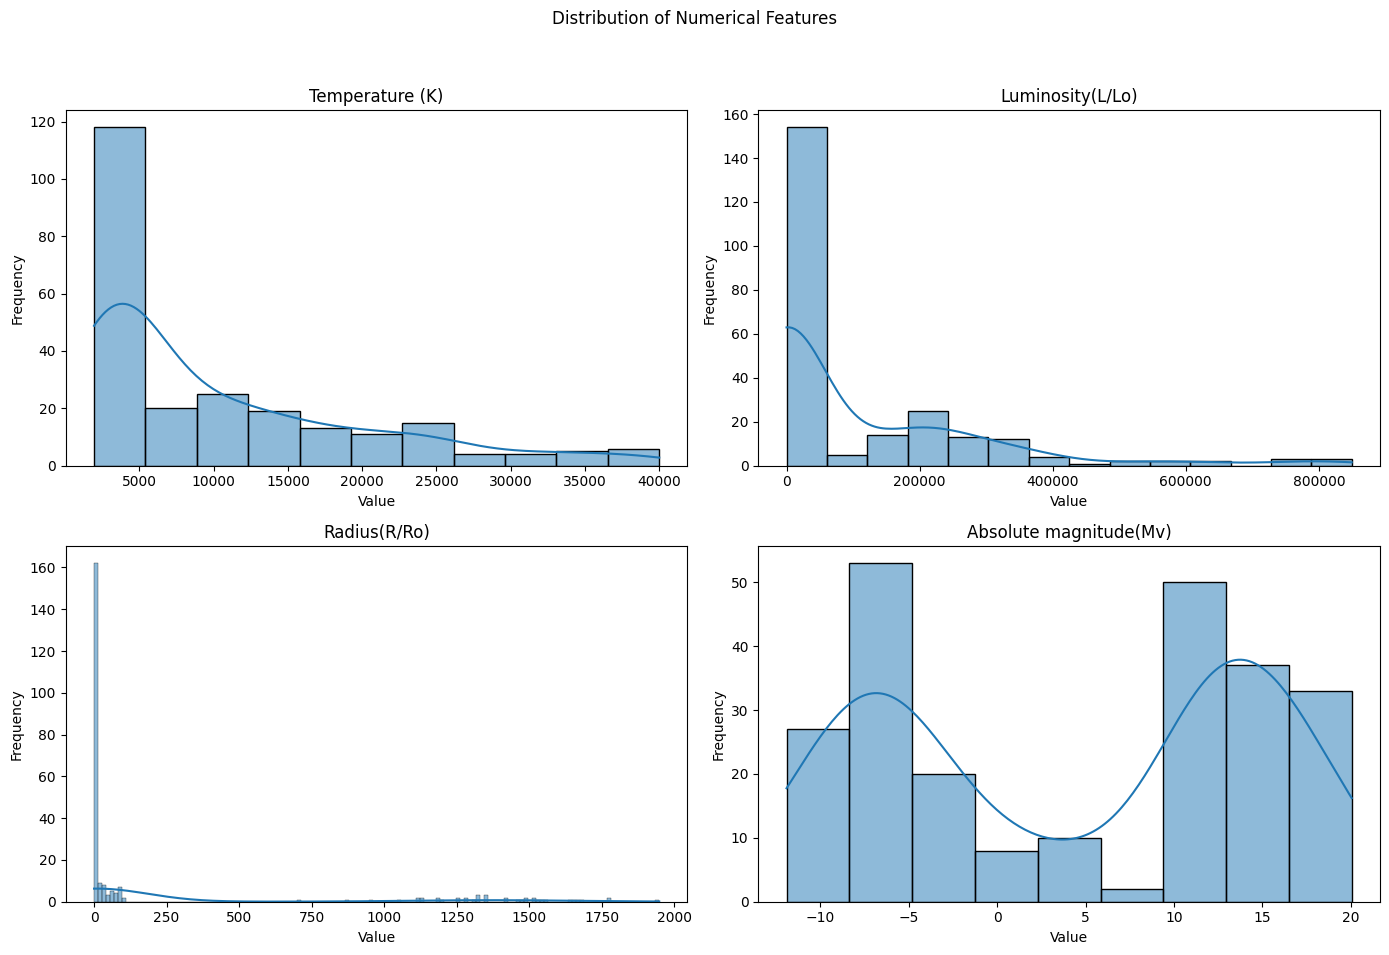

In [20]:
# Defining a list of numerical column names.
columns = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# The code plots histograms for the numerical columns in the dataframe using Matplotlib and Seaborn.
# The plot_numerical_distributions() function takes the DataFrame and the list of column names as input
# and creates histograms for each of the specified numerical columns to visualize their distributions.
plot_numerical_distributions(df, columns)

### Observations:
#### Temperature (K): The distribution is right-skewed, indicating that most stars have a lower temperature, with a few stars having very high temperatures.
#### Luminosity(L/Lo): This feature is highly right-skewed, suggesting that most stars have low luminosity relative to the sun, with a few exceptions having extremely high luminosity.
#### Radius(R/Ro): Similar to luminosity, the radius distribution is also right-skewed, with most stars being smaller compared to a few with very large radii.
#### Absolute magnitude(Mv): The distribution shows a wide range of values, indicating a variety of star brightness levels.

## Correlation Analysis: Check for correlations between the numerical features.

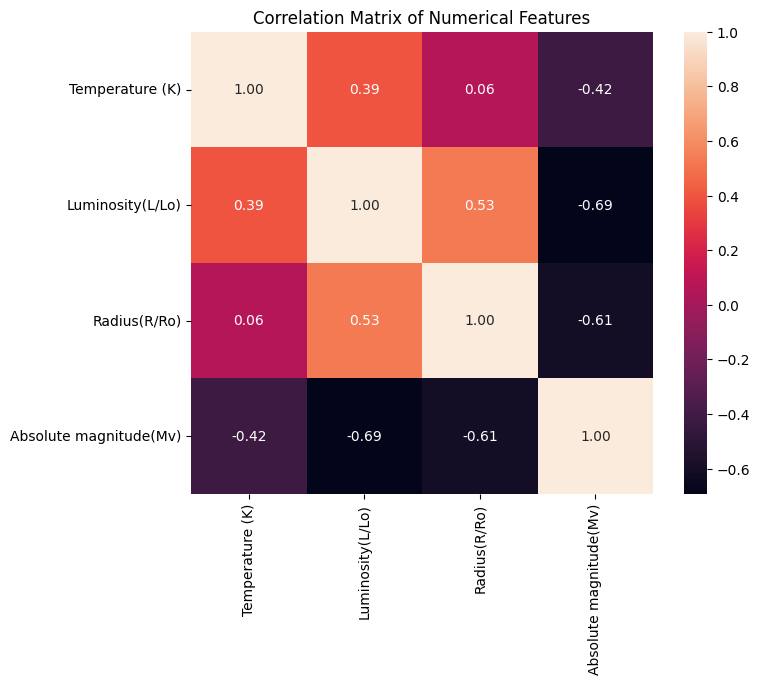

In [21]:
# The code plots a heatmap to visually represent the correlation matrix of numerical features in a dataset.
# The plot_correlation_matrix() function takes the DataFrame and the list of column names previously defined as input
# and creates a heatmap showing the pairwise correlation between the specified numerical columns.
plot_correlation_matrix(df, columns=columns)

### Observations from the Correlation Matrix:
#### Temperature and Luminosity: There is a moderate positive correlation (0.39), suggesting that higher temperatures often correspond to higher luminosities.
#### Temperature and Radius: A very low positive correlation (0.06), indicating almost no relationship between temperature and radius.
#### Temperature and Absolute Magnitude: There is a strong negative correlation (-0.42), indicating that stars with higher temperatures tend to have lower (brighter) absolute magnitudes.
#### Luminosity and Radius: A moderate positive correlation (0.53) exists between luminosity and radius, suggesting that stars with larger radii tend to be more luminous.
#### Luminosity and Absolute Magnitude: There is a strong negative correlation (-0.69), showing that more luminous stars generally have lower (brighter) absolute magnitudes.
#### Radius and Absolute Magnitude: Similar to luminosity, there is a strong negative correlation (-0.61) between radius and absolute magnitude, indicating that larger stars are generally brighter.

## Feature Relationships: Use scatter plots or pair plots to visualize relationships between pairs of features to uncover any trends or patterns.

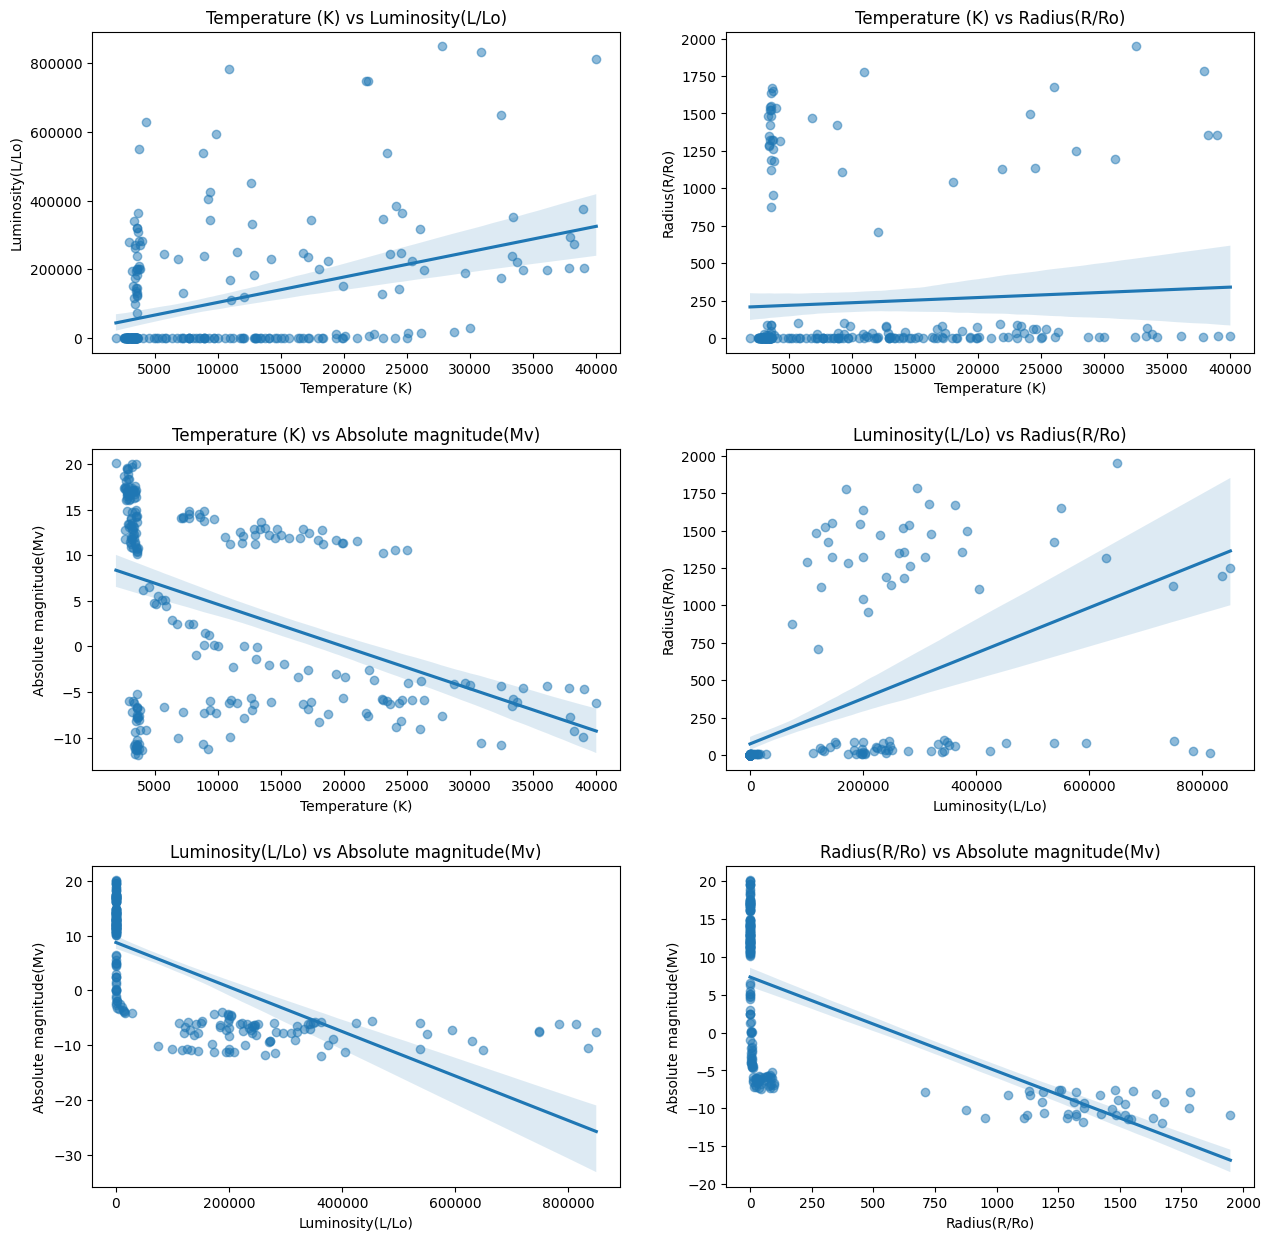

In [22]:
# Defining a list of tuples, where each tuple contains a pair of column names.
pairs = [
    ('Temperature (K)', 'Luminosity(L/Lo)'),
    ('Temperature (K)', 'Radius(R/Ro)'),
    ('Temperature (K)', 'Absolute magnitude(Mv)'),
    ('Luminosity(L/Lo)', 'Radius(R/Ro)'),
    ('Luminosity(L/Lo)', 'Absolute magnitude(Mv)'),
    ('Radius(R/Ro)', 'Absolute magnitude(Mv)')
]

# This code plots a grid of scatter plots for the specified pairs of numerical columns.
# The plot_scatter_grid() function takes the DataFrame and the list of column pairs as input
# and creates a grid of scatter plots, with each plot showing the relationship between the two columns in the pair.
plot_scatter_grid(df, pairs)

### Observations from the pairplots:
#### Temperature vs Luminosity: The plot shows some positive correlation, particularly for higher temperatures where luminosity increases noticeably.
#### Temperature vs Radius: There is a weak relationship with some larger radii at lower temperatures, which might suggest cooler stars like giants or supergiants have larger radii.
#### Temperature vs Absolute Magnitude: A negative trend is evident, where higher temperatures often correspond to brighter stars (lower absolute magnitude).
#### Luminosity vs Radius: This plot shows a clear positive relationship, indicating that as stars become more luminous, they also tend to have larger radii, consistent with the correlation coefficient.
#### Luminosity vs Absolute Magnitude: There's a strong negative relationship, with more luminous stars being significantly brighter, which aligns with theoretical expectations.
#### Radius vs Absolute Magnitude: A negative correlation is visible here as well, with larger stars typically being brighter.

## Categorical Analysis: Examine the distribution of categorical features like Star type, Star color, and Spectral Class.

C:\Users\Acer\AppData\Local\Temp\ipykernel_23428\495121396.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='viridis') # Plot the bar plot.
C:\Users\Acer\AppData\Local\Temp\ipykernel_23428\495121396.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='viridis') # Plot the bar plot.
C:\Users\Acer\AppData\Local\Temp\ipykernel_23428\495121396.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='vi

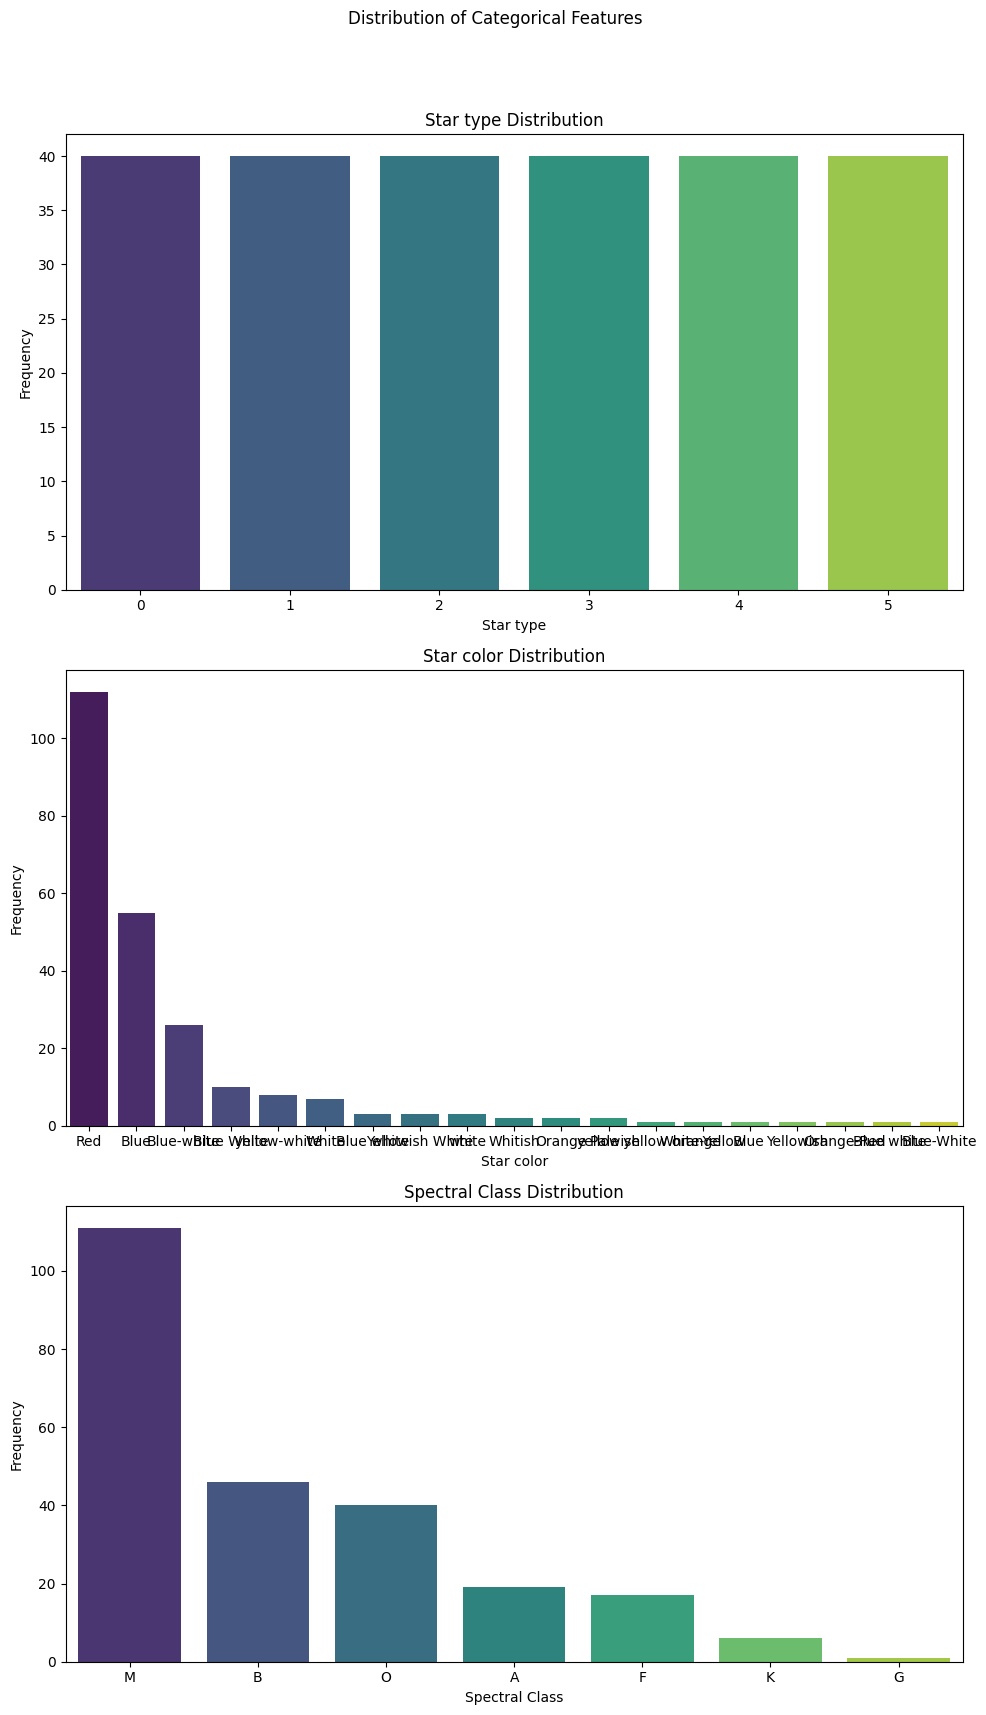

In [23]:
# Defining a list of categorical column names.
categories = ['Star type', 'Star color', 'Spectral Class']

# This code creates a figure with three axes to plot the distributions of three categorical features: 'Star Type', 'Star Color', and 'Spectral Class'.
# Count plots for categorical features.
# The plot_categorical_distributions() function takes the DataFrame and the list of categorical column names as input
# and creates count plots (or bar plots) for each categorical column, showing the frequency of each category.
plot_categorical_distributions(df, categories)

### Observations:
#### Star Type Distribution: The dataset contains a variety of star types, with some types being more frequent than others. This could reflect different stages of star evolution or specific classes of stars being more common in the observed sample.
#### Star Color Distribution: There is a diverse range of star colors represented, which correlates with the temperature and spectral class of the stars. Some colors appear more frequently, possibly indicating common temperatures and compositions in the dataset.
#### Spectral Class Distribution: The spectral class, which categorizes stars based on their spectral characteristics, shows a varied distribution. Some classes are more prevalent, which might be linked to the common physical properties of stars within those classes. Shows a highly imbalanced graph.

## Outlier Detection: Identify any outliers in the numerical data.

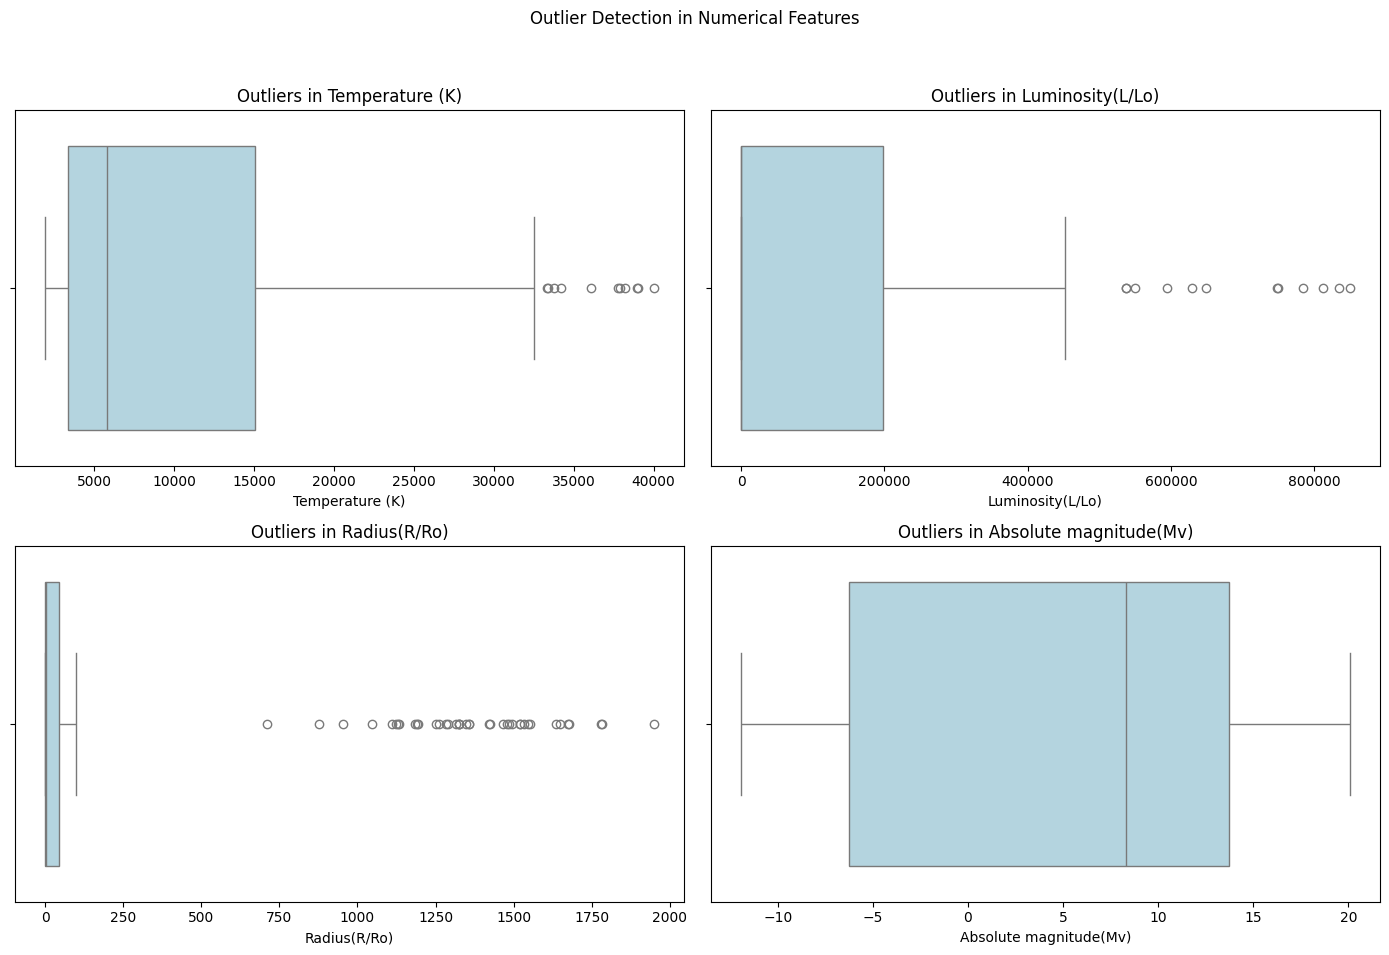

In [24]:
# This code creates a 2x2 figure of box plots to visually identify outliers in the dataset's numerical features, using Seaborn and Matplotlib libraries.
# Boxplots for detecting outliers in numerical features.
# The plot_boxplots_for_outliers() function takes the DataFrame and the list of numerical column names as input
# and creates a 2x2 grid of box plots, with each plot showing the distribution and potential outliers for one of the specified numerical columns.
plot_boxplots_for_outliers(df, columns=columns)

### Observations on Outliers:
#### Temperature (K): There are a few outliers on the higher end, indicating some stars with exceptionally high temperatures.
#### Luminosity(L/Lo): This feature shows significant outliers, particularly on the higher end, suggesting some stars with extraordinarily high luminosity compared to the majority.
#### Radius(R/Ro): Similar to luminosity, there are notable outliers indicating some stars with much larger radii than typical stars in the dataset.
#### Absolute Magnitude(Mv): There are outliers on both the lower and higher ends, indicating stars that are either much brighter or dimmer than the average star in the dataset.
#### These outliers could represent rare or unique types of stars, or they might be due to measurement errors or data entry issues. It would be important to further investigate these outliers to understand their nature and ensure the accuracy of the dataset.

## Data Cleaning: Standardize the 'Star color' entries to have consistent categorizations.

In [26]:
# Consolidate similar color names by mapping them to a standardized form.
# This helps to ensure consistent naming conventions for subsequent analysis.
color_mapping = {
    'Blue White': 'Blue-White',
    'Blue white': 'Blue-White',
    'Blue-White': 'Blue-White',
    'blue white': 'Blue-White',
    'Blue': 'Blue',
    'White': 'White',
    'white': 'White',
    'Whitish': 'White',
    'yellow-white': 'Yellow-White',
    'Yellowish White': 'Yellow-White',
    'White-Yellow': 'Yellow-White',
    'yellowish': 'Yellowish',
    'Yellowish': 'Yellowish',
    'Orange': 'Orange',
    'Pale yellow orange': 'Pale Yellow Orange',
    'Orange-Red': 'Orange-Red'
}

# Replacing the values in the 'Star color' column with the standardized names from the color_mapping dictionary.
df['Star color'] = df['Star color'].replace(color_mapping)

# Removing leading/trailing whitespace and convert the 'Star color' values to lowercase for consistency.
df['Star color'] = df['Star color'].str.strip().str.lower()

# Displaying the value counts (frequencies) for the cleaned 'Star color' column.
cleaned_star_color_counts = df['Star color'].value_counts()
cleaned_star_color_counts

Star color
red                   112
blue                   56
blue-white             41
white                  12
yellow-white           12
yellowish               3
orange                  2
pale yellow orange      1
orange-red              1
Name: count, dtype: int64

## Data pre-processing

In [163]:
# Identifying the 'Spectral Class' categories that have only one instance.
# These rare classes can be problematic for modeling, so I'll filter them out.
class_counts = df['Spectral Class'].value_counts()
classes_to_keep = class_counts[class_counts > 1].index

# Filtering the DataFrame to keep only the 'Spectral Class' categories with more than one instance.
df = df[df['Spectral Class'].isin(classes_to_keep)]

In [164]:
# Converting the categorical 'Star color' and 'Spectral Class' columns to numerical labels.
# This is necessary for the machine learning algorithms that require numerical input features.
label_encoder = LabelEncoder()

# Encoding 'Spectral Class' using the label_encoder.
df['Spectral Class'] = label_encoder.fit_transform(df['Spectral Class'])

# Encoding 'Star color' using the label_encoder.
df['Star color'] = label_encoder.fit_transform(df['Star color'])
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,4
1,3042,0.000500,0.1542,16.60,0,10,4
2,2600,0.000300,0.1020,18.70,0,10,4
3,2800,0.000200,0.1600,16.65,0,10,4
4,1939,0.000138,0.1030,20.06,0,10,4


In [165]:
# Separating the features (X) and target variable (y).
X = df.drop(['Spectral Class'],axis=1)
y = df.loc[:,'Spectral Class']

In [166]:
# Splitting the data into training and testing sets.
# This allows us to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
# Standardizing the feature values to have a mean of 0 and a standard deviation of 1.
# This is a common preprocessing step for many machine learning algorithms.
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


In [168]:
# Using SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution in the training data.
# This helps to mitigate the issue of imbalanced classes, which can adversely affect model performances.
smote = SMOTE(k_neighbors=2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(scaled_X_train, y_train)

In [57]:
# Performing Principal Component Analysis (PCA) to reduce the dimensionality of the feature space.
# This can help to improve model performance and interpretability.
pca = PCA()
pca.fit(X_resampled)
exp_variance = pca.explained_variance_ratio_

Text(0.5, 0, 'Principal Component number')

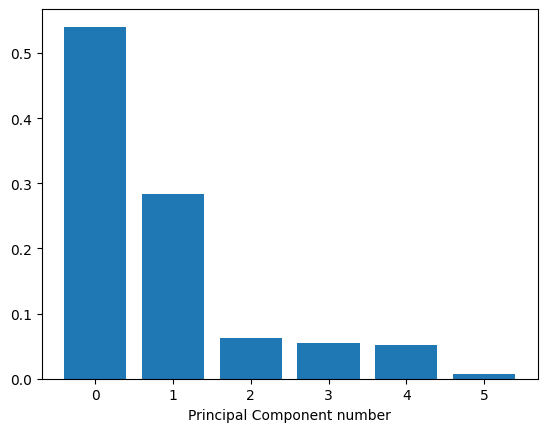

In [58]:
# Plotting a bar chart to visualize the explained variance ratio for each principal component.
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component number')

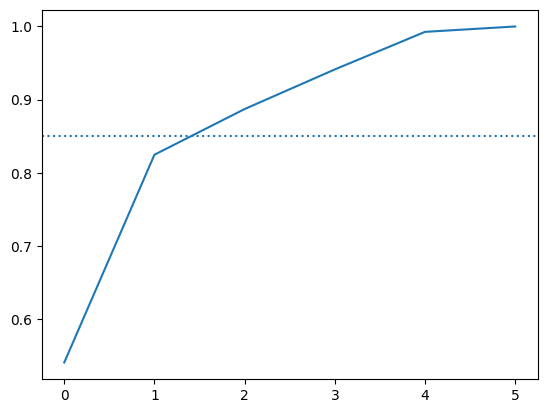

In [59]:
# Calculating the cumulative explained variance from the explained variance of each principal component.
cum_exp_variance = np.cumsum(exp_variance)

# Creating a figure and a set of subplots with one Axes object (ax).
fig, ax = plt.subplots()

# Plotting the cumulative explained variance on the Axes object (ax).
# The x-coordinates are inferred from the length of cum_exp_variance, which represents the principal component numbers.
ax.plot(cum_exp_variance)

# Adding a horizontal line at y=0.85 (85% explained variance) to the plot.
# The line style is set to a dotted line (':').
ax.axhline(y=0.85, linestyle=':')

#### calculating the cumulative explained variance from the individual explained variances of principal components. Then plotting this cumulative explained variance and adding a horizontal dotted line at 85% to help visualize how many principal components are needed to explain at least 85% of the variance in the data.

In [60]:
# Based on the cumulative explained variance plot, we can see that 2 principal components capture ~85% of the variance.
# So we'll use PCA with n_components=2 to reduce the dimensionality of the feature space.
pca.fit(X_resampled)
X_train_pca = pca.transform(X_resampled)
X_test_pca = pca.transform(scaled_X_test)

In [61]:
# Creating a DataFrame with the PCA-transformed features for easier plotting.
X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=['PCA1', 'PCA2'])

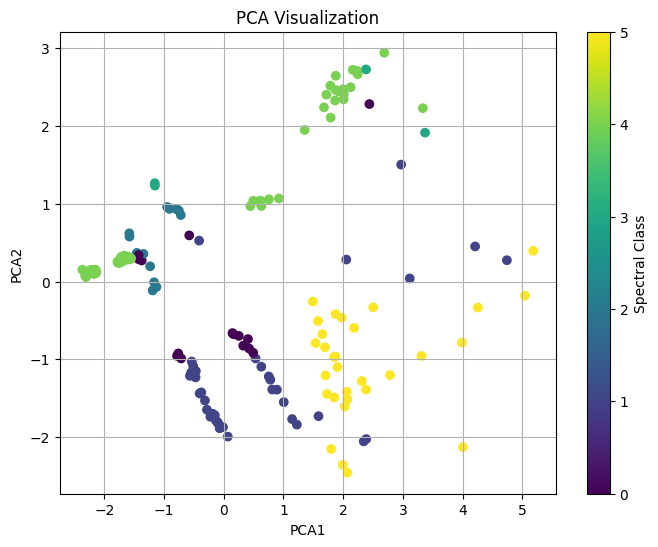

In [69]:
# Plotting a scatter plot of the PCA-transformed features, colored by the target variable ('Spectral Class').
# This can help to visualize the separability of the classes in the reduced feature.
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=y_train, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Visualization')
plt.colorbar(label='Spectral Class')
plt.grid(True)
plt.show()

### Supervised Methods

In [169]:
# creating a list of models to compare.
supervised_models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

# creating a dictionary of hyperparameters to tune for each model.
supervised_hyperparameters = {

    'LogisticRegression': {
        'penalty': [None, 'l2', 'l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
    },

    'SVC': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },

    'KNeighborsClassifier': {
        'n_neighbors': np.arange(9),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [2, 3, 4, 5],
        'min_samples_leaf': [10, 20, 30],
        'min_samples_split': [20, 30, 40]
    },
    
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 150, 200, 250],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [5, 10, 15, 20]
    }
}

In [170]:
# Performing hyperparameter tuning on the supervised models to find the best model.
supervised_results = grid_search_comparison(supervised_models, supervised_hyperparameters, X_resampled, y_resampled)

c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarni

In [171]:
supervised_results

[{'model': 'LogisticRegression',
  'high score': 0.9503703703703702,
  'best parameters': {'C': 0.001, 'penalty': None, 'solver': 'newton-cg'}},
 {'model': 'SVC',
  'high score': 0.9553703703703704,
  'best parameters': {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}},
 {'model': 'KNeighborsClassifier',
  'high score': 0.9799999999999999,
  'best parameters': {'metric': 'manhattan',
   'n_neighbors': 1,
   'weights': 'uniform'}},
 {'model': 'DecisionTreeClassifier',
  'high score': 0.9422222222222222,
  'best parameters': {'criterion': 'entropy',
   'max_depth': 5,
   'min_samples_leaf': 10,
   'min_samples_split': 20}},
 {'model': 'RandomForestClassifier',
  'high score': 0.9872222222222221,
  'best parameters': {'criterion': 'gini',
   'max_depth': 10,
   'n_estimators': 100}}]

In [176]:
# The Random Forest classifier performed the best.
# training the Random Forest classifier on its optimal parameters.
rf_best = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100)
rf_best.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=10)

Accuracy: 91.67%


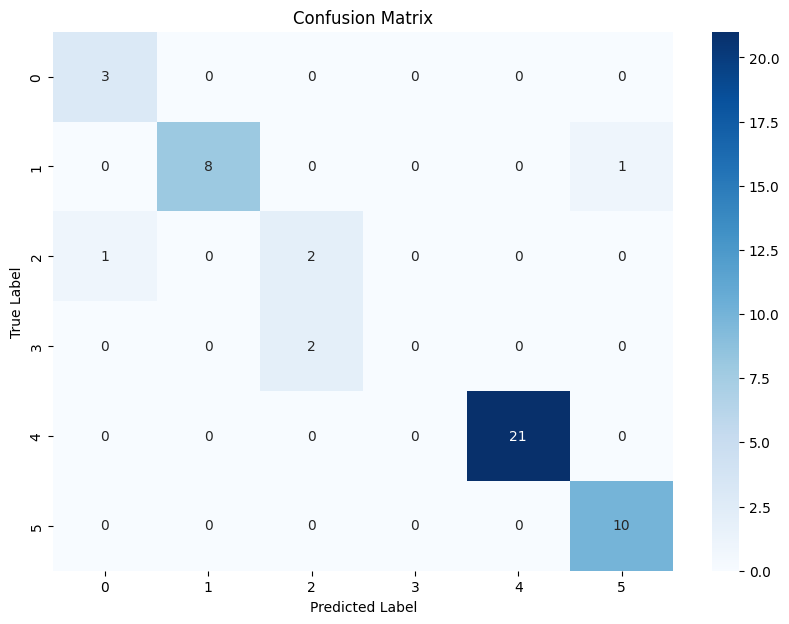

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9
           2       0.50      0.67      0.57         3
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00        21
           5       0.91      1.00      0.95        10

    accuracy                           0.92        48
   macro avg       0.69      0.76      0.72        48
weighted avg       0.89      0.92      0.90        48



c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [177]:
# Evaluating the supervised model's performance.
evaluate_supervised_model(rf_best, scaled_X_test, y_test)

### Unsupervised Methods

In [178]:
# creating a list of models to compare
unsupervised_models = [AgglomerativeClustering(), DBSCAN(), SpectralClustering(), KMeans(), GaussianMixture()]

# creating a dictionary of hyperparameters to tune for each model
unsupervised_hyperparameters = {
    
    'AgglomerativeClustering': {
        'n_clusters': [2, 3, 4, 5],
        'linkage': ['ward', 'complete', 'average', 'single']
    },
    
    'DBSCAN': {
        'eps': [0.1, 0.5],
        'min_samples': [2, 3, 4, 5],
        'metric': ['euclidean', 'manhattan', 'cosine']
    },
    
    'SpectralClustering': {
        'n_clusters': [2, 3, 6, 8],
        'eigen_solver': ['arpack', 'lobpcg', 'amg']
    },
    
    'KMeans': {
        'n_clusters': [2, 3, 4, 5],
        'init': ['k-means++', 'random']
    },
    
    'GaussianMixture': {
        'n_components': [2, 3, 4, 5],
        'covariance_type': ['full', 'tied', 'diag', 'spherical']
    }
}

In [201]:
# Performing hyperparameter tuning on the unsupervised models to find the best model.
unsupervised_results = grid_search_comparison(unsupervised_models, unsupervised_hyperparameters, X_train_pca)

c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

In [202]:
unsupervised_results

[{'model': 'AgglomerativeClustering',
  'high score': 0.5823200511711084,
  'best parameters': {'linkage': 'average', 'n_clusters': 5}},
 {'model': 'DBSCAN',
  'high score': 0.5366608054481252,
  'best parameters': {'eps': 0.5, 'metric': 'manhattan', 'min_samples': 5}},
 {'model': 'SpectralClustering',
  'high score': 0.5573527243356491,
  'best parameters': {'eigen_solver': 'lobpcg', 'n_clusters': 8}},
 {'model': 'KMeans',
  'high score': 0.5982919783081804,
  'best parameters': {'init': 'k-means++', 'n_clusters': 5}},
 {'model': 'GaussianMixture',
  'high score': 0.5910392909613619,
  'best parameters': {'covariance_type': 'tied', 'n_components': 5}}]

In [203]:
# Kmeans performed the best clustering based on the silhouette score provided.
# training the KMeans on its optimal parameters.
km_best = KMeans(init='k-means++', n_clusters=5)
km_best.fit(X_train_pca)

c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=5)

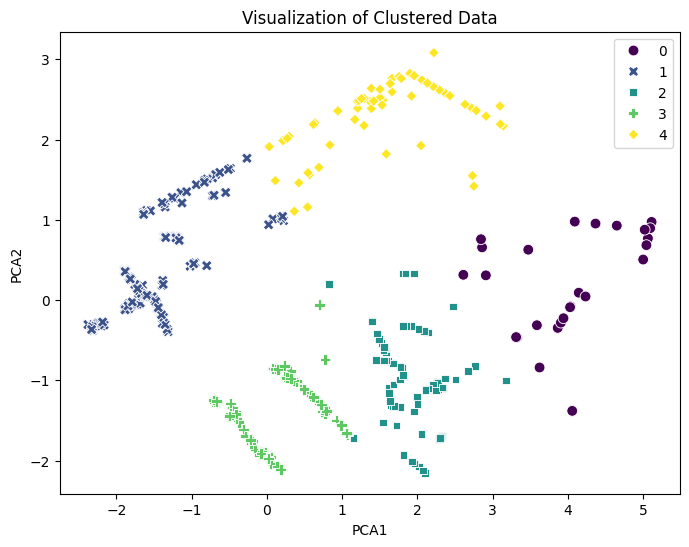

c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

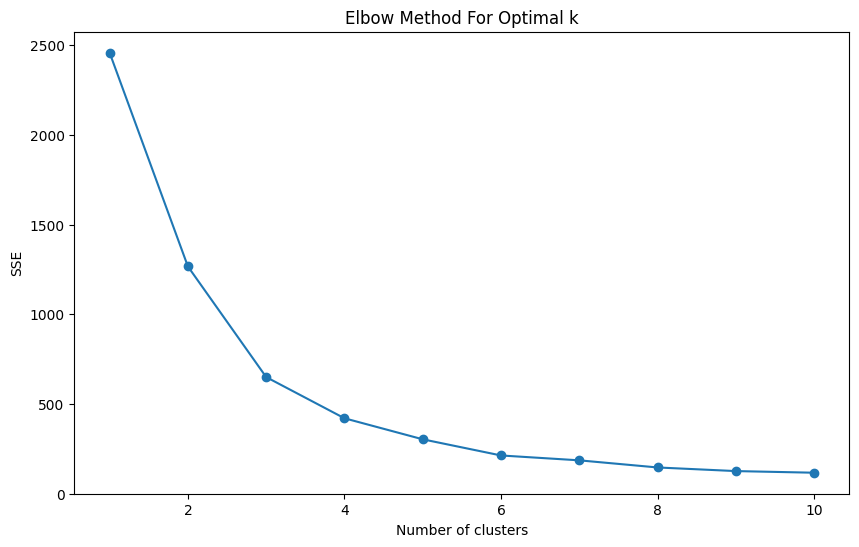

In [204]:
# Evaluating the clustering performance and cross validating the number of clusters with the elbow graph.
evaluate_unsupervised_model(X_train_pca, km_best, max_clusters=10)

#### The above elbow graph shows the best number of cluster is 5

### Multi Layer Perceptron

In [181]:
# Checking the input size for the MLP.
input_size = X_resampled[0].shape
input_size

(6,)

In [253]:
# Defining the configs for the MLP.
configs = [
    {'nodes': 128}, # 1st layer
    {'nodes': 256}, # 2nd layer
    {'nodes': 128, 'l2': 0.0001} # 3rd layer
]

# Adding an exponential decay on the learning rate.
exp_dcy = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, 
                                                      decay_steps=2500, 
                                                      decay_rate=0.9)

# Creating the model based on the configs. 
mlp_model = create_mlp_model(layer_configs=configs, 
                                  optimizer='adam', 
                                  loss='sparse_categorical_crossentropy', 
                                  input_shape=input_size, 
                                  num_classes=6, 
                                  output_activation='softmax',
                                  learning_rate=exp_dcy)

In [254]:
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,590 (264.02 KB)

 Trainable params: 67,590 (264.02 KB)

 Non-trainable params: 0 (0.00 B)

In [255]:
# Training the MLP.
mlp_model_history, mlp_model_time = train_model(mlp_model, X_resampled, y_resampled, epochs=20, batch_size=16, validation_data=(scaled_X_test, y_test),
                                                early_stopping=True, es_monitor='val_loss', es_patience=2, verbose=1)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2541 - loss: 1.7742 - val_accuracy: 0.6458 - val_loss: 1.5925
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 1.5845 - val_accuracy: 0.7292 - val_loss: 1.4091
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 1.4236 - val_accuracy: 0.7292 - val_loss: 1.2270
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 1.2692 - val_accuracy: 0.7292 - val_loss: 1.0607
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 1.0864 - val_accuracy: 0.7500 - val_loss: 0.9210
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7231 - loss: 0.9873 - val_accuracy: 0.7500 - val_loss: 0.8059
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7395 - loss: 0.8656 - val_accuracy: 0.7917 - val_loss: 0.7263
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7605 - loss: 0.7490 - val_accuracy: 0.7708 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy: 91.67%


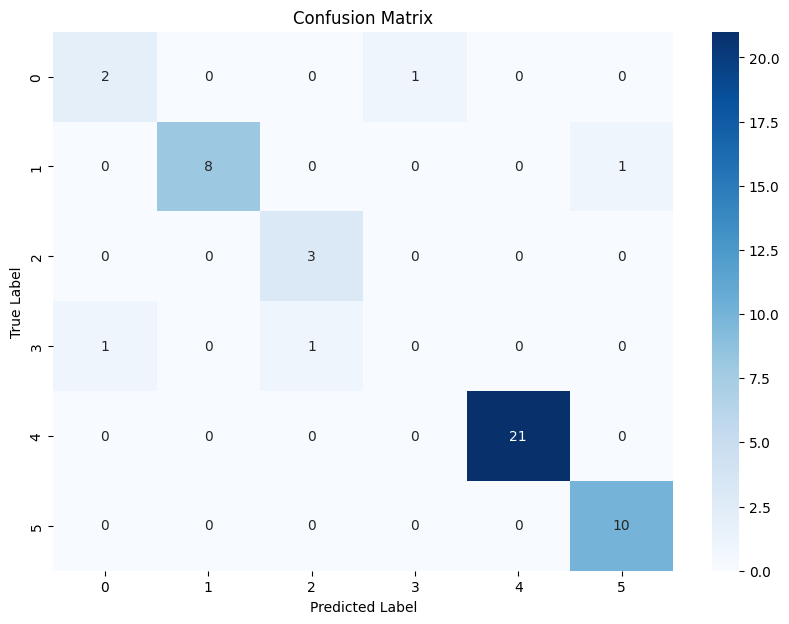

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      0.89      0.94         9
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00        21
           5       0.91      1.00      0.95        10

    accuracy                           0.92        48
   macro avg       0.72      0.76      0.74        48
weighted avg       0.90      0.92      0.91        48



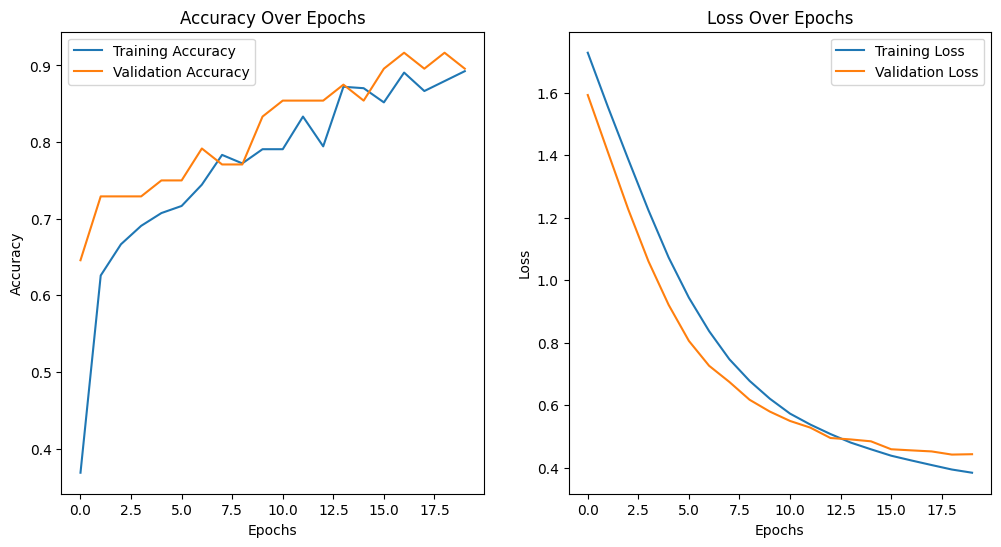

In [256]:
# Evaluating the MLPs performance.
evaluate_model(mlp_model, scaled_X_test, y_test, history=mlp_model_history)

### CNN

In [190]:
# Defining the Input shape for the CNN.
input_shape = (6, 1)

# Defining the configs for the CNN.
configs = [
    {'type': 'conv1d', 'filters': 8, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': 2},
    {'type': 'conv1d', 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': 2},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 64, 'activation': 'relu'}
]

# Adding an inverse time decay on the learning rate.
inv_dcy = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, 
                                                      decay_steps=400, 
                                                      decay_rate=0.9)

# Creating the model based on the configs. 
cnn_model = create_cnn_model(configs,
                            optimizer='adam', 
                            loss='sparse_categorical_crossentropy', 
                            input_shape=input_shape, 
                            num_classes=6, 
                            output_activation='softmax',
                            learning_rate=inv_dcy)

c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [191]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 8)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 16)          │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,910 (7.46 KB)

 Trainable params: 1,910 (7.46 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
# Training the CNN.
cnn_model_history, cnn_model__time = train_model(cnn_model, X_resampled, y_resampled, epochs=20, batch_size=32, validation_data=(scaled_X_test, y_test),
                                                 early_stopping=True, es_monitor='val_loss', es_patience=2, verbose=1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2085 - loss: 1.7971 - val_accuracy: 0.3333 - val_loss: 1.7142
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.7263 - val_accuracy: 0.6667 - val_loss: 1.6694
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5612 - loss: 1.6343 - val_accuracy: 0.5417 - val_loss: 1.6038
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6229 - loss: 1.5251 - val_accuracy: 0.7083 - val_loss: 1.4780
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6803 - loss: 1.3583 - val_accuracy: 0.7292 - val_loss: 1.3271
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7061 - loss: 1.1864 - val_accuracy: 0.7292 - val_loss: 1.1522
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7428 - loss: 1.0188 - val_accuracy: 0.7708 - val_loss: 0.9978
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7448 - loss: 0.8679 - val_accuracy: 0.8125 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy: 91.67%


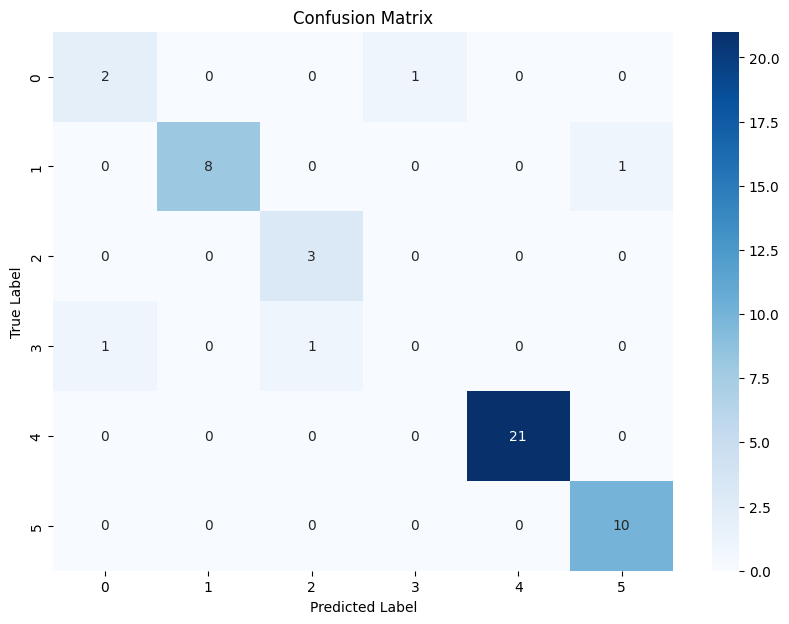

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      0.89      0.94         9
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00        21
           5       0.91      1.00      0.95        10

    accuracy                           0.92        48
   macro avg       0.72      0.76      0.74        48
weighted avg       0.90      0.92      0.91        48



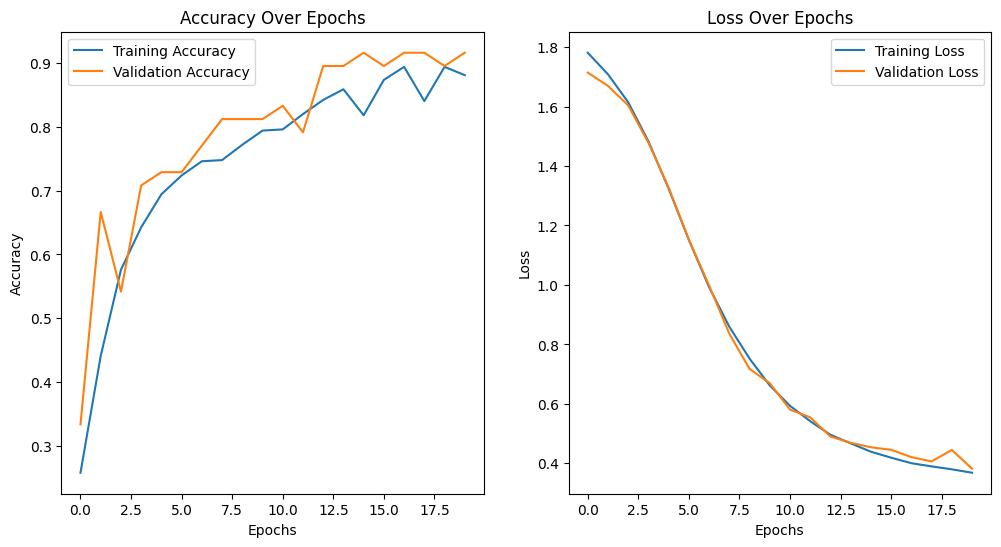

In [193]:
# Evaluating the MLPs performance.
evaluate_model(cnn_model, scaled_X_test, y_test, history=cnn_model_history)